In [14]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

### San Francisco

In [3]:
census_tracts =  gpd.read_file('../../data/SpatialData/SanFran/Census_2020_Tracts_SanFran/Census_Tracts_SanFran_2020.shp')
census_tracts = census_tracts.sort_values(by='tractce')
census_tracts = census_tracts[census_tracts['tractce']!='980401']

gdf = gpd.read_file("../../data/SpatialData/SanFran/GentrificationIndex_SpatialDomain.shp")

# Clip tracts to Bay Area
gdf_bay = gpd.clip(gdf, census_tracts)

gdf_bay = gdf_bay[gdf_bay.geometry.type == 'Polygon']

gdf_bay['GEOID'] = gdf_bay['GEOID'].astype(int)
gdf_bay['GEOID'] = gdf_bay['GEOID'].astype(str)

In [25]:
order = ["Low-Income/Susceptible to Displacement", "Ongoing Displacement", "At Risk of Gentrification",
    "Early/Ongoing Gentrification",'Advanced Gentrification', "Stable Moderate/Mixed Income","At Risk of Becoming Exclusive", 
         "Becoming Exclusive", "Stable/Advanced Exclusive", "High Student Population"]

# Make sure classification_new is treated as categorical in the right order
gdf_bay["Typology"] = pd.Categorical(
    gdf_bay["Typology"], categories=order, ordered=True)

# Count with all categories (missing ones get 0)
counts_sf = gdf_bay["Typology"].value_counts().reindex(order, fill_value=0)

### Melbourne

In [23]:
city='melbourne'
central_suburbs = gpd.read_file(f"../../data/SpatialData/MelbourneSuburbs.shp")
central_suburbs = central_suburbs[['SAL_NAME21', 'geometry']]

classifications = pd.read_csv(f"../../data/GentrificationIndex/MelbourneIndex/FromGuardian.csv")
classifications = classifications.merge(central_suburbs, on='SAL_NAME21', how='left')

filtered_df = classifications[classifications['geometry'].notnull()].copy()

mapping_idx = {1: 'Susceptible to displacement', 2: "Low-income households being displaced",
           4: "Early gentrification", 5: "Mixed income", 6:"Risk of exclusivity", 7: "Becoming exclusive",
           8 : "Exclusive"}

filtered_df['classification_new'] = filtered_df['Classification'].map(mapping_idx)

order = ["Susceptible to displacement", "Low-income households being displaced", "At risk of gentrification",
    "Early gentrification","Mixed income","Risk of exclusivity", "Becoming exclusive", "Exclusive"]

# Make sure classification_new is treated as categorical in the right order
filtered_df["classification_new"] = pd.Categorical(
    filtered_df["classification_new"], categories=order, ordered=True)

# Count with all categories (missing ones get 0)
counts_melb = filtered_df["classification_new"].value_counts().reindex(order, fill_value=0)

### Manchester

In [17]:
lsoas =  gpd.read_file('../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
manchester_lsoas=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]

manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters
central_lsoas = manchester_lsoas[manchester_lsoas.intersects(buffer)]

g_index = pd.read_csv("../../data/GentrificationIndex/ManchesterIndex/manc_index.csv") 
g_index_df = g_index.merge(central_lsoas[['LSOA11NM', 'geometry']], on='LSOA11NM', how='left')
g_index_gdf = gpd.GeoDataFrame(g_index_df, geometry='geometry', crs="EPSG:27700")

### Plot all three

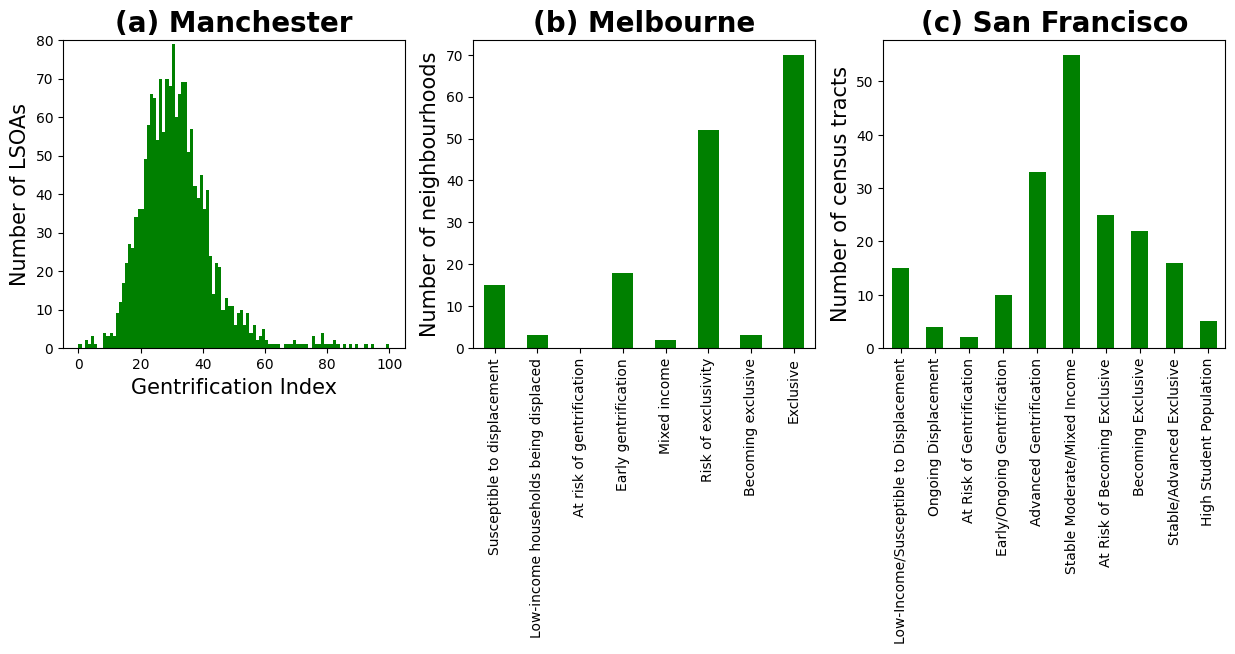

In [33]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))

# (a) Manchester histogram
axs[0].hist(g_index_gdf['gi_n'], bins=100, color='green')
axs[0].set_ylim(0, 80)
axs[0].set_xlabel('Gentrification Index', fontsize=15)
axs[0].set_ylabel('Number of LSOAs', fontsize=15)
axs[0].set_title('(a) Manchester', fontsize=20, fontweight='bold')

# (b) Melbourne barplot
counts_melb.plot(ax=axs[1], kind="bar", color="green")
axs[1].set_xlabel("")
axs[1].set_ylabel("Number of neighbourhoods", fontsize=15)
axs[1].set_title('(b) Melbourne', fontsize=20, fontweight='bold')
axs[1].tick_params(axis='x', rotation=90)

# (c) San Francisco barplot
counts_sf.plot(ax=axs[2], kind="bar", color="green")
axs[2].set_xlabel("")
axs[2].set_ylabel("Number of census tracts", fontsize=15)
axs[2].set_title('(c) San Francisco', fontsize=20, fontweight='bold')
axs[2].tick_params(axis='x', rotation=90)

fig.savefig("Figures/Combined_GI.png", dpi=300, bbox_inches="tight")